In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [91]:
deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
    'create_using': nx.DiGraph
}

graph = nice.graph.nmu_graph(100, 3, **kw)

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['consumption'] = 500 * edge['distance']
        edge['cost'] = edge['time']

In [92]:
'''
Places and Stations
'''
deep_reload(nice)

n = 15

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

paths = nice.optimization.get_paths(
    graph, terminals = places, k = 10, weight = 'time',
)

In [93]:
paths[46]

{'origin': 36,
 'destination': 61,
 'index': 2,
 'path': [36,
  50,
  77,
  20,
  72,
  64,
  31,
  37,
  42,
  97,
  17,
  29,
  49,
  18,
  98,
  76,
  51,
  82,
  35,
  26,
  61]}

In [210]:
'''
Adding classes
'''
deep_reload(nice)

for place in places:

    destinations = set(places) - set([place])
    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()
    
    graph._node[place]['flows'] = {p: demands[i] for i, p in enumerate(destinations)}
    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['power'] = 80e3
    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:

    path['capacity'] = 80 * 3.6e6 / 2
    path['penalty'] = 2
    path['_class'] = nice.optimization.Path

In [211]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Parameters Built: 0.028458118438720703
Variables Built: 0.38266634941101074
Constraints Built: 0.6729247570037842
Objective Built: 0.022344112396240234


In [212]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

network.model.scale = 10
network.solve(**kw)
solution = network.solution

Problem Solved: 1.7600748538970947
Results Collected: 0.0504908561706543


In [213]:
# solution._node

In [214]:
# [p['results'] for p in network.paths if p['results']['volume']]

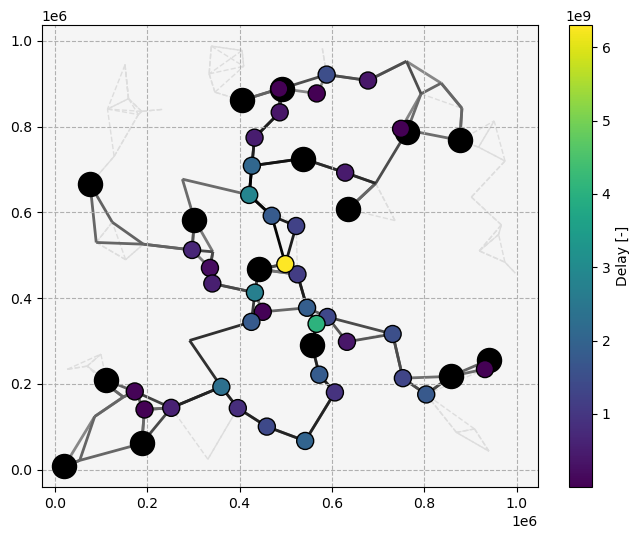

In [215]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

eps = 0

selection = (
    [(s, t) for s, a in solution._adj.items() \
     for t, e in a.items() if e['volume'] > eps]
)

kw = {
    'nodes': {
        'field': 'energy',
        'cmap': nice.plot.Colormap(),
        'selection': [k for k, n in solution._node.items() if n.get('energy', 0) > 0],
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
            # 'vmin': .5,
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'volume',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
        # 'colorbar': {
        #     'label': 'Edge Flow',
        # },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 2,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [197]:
solution._adj

{0: {53: {'object': <nice.optimization.edge.Edge at 0x7f6db199c050>,
   'distance': 58001.554707514275,
   'speed': 29.051388888888887,
   'time': 1996.515723545933,
   'consumption': 29000777.35375714,
   'cost': 1996.515723545933,
   'unit_cost': 1996.515723545933,
   'volume': 0.0},
  63: {'object': <nice.optimization.edge.Edge at 0x7f6db199e360>,
   'distance': 91763.04959607111,
   'speed': 29.051388888888887,
   'time': 3158.645872217393,
   'consumption': 45881524.798035555,
   'cost': 3158.645872217393,
   'unit_cost': 3158.645872217393,
   'volume': 0.0},
  73: {'object': <nice.optimization.edge.Edge at 0x7f6daf331760>,
   'distance': 112676.60156980863,
   'speed': 29.051388888888887,
   'time': 3878.527185077316,
   'consumption': 56338300.784904316,
   'cost': 3878.527185077316,
   'unit_cost': 3878.527185077316,
   'volume': 0.0}},
 1: {5: {'object': <nice.optimization.edge.Edge at 0x7f6daf3317f0>,
   'distance': 50113.26261124217,
   'speed': 29.051388888888887,
   'time'

In [ ]:
'''
Adding Delay
'''

# energy = 35 * 3.6e6
# power = 80e3

# m = 1 / (energy / power)
# rho = np.linspace(0, 1, 10)
# c = np.arange(1, 11, 1)

# queue = nice.queue.Queue(m = m, bounds = (0, 24 * 3600))

# for station in stations:

#     station_c = rng.choice(c)

#     volumes = rho * m * station_c
#     delays = queue.interpolate(rho, station_c)

#     graph._node[station]['volumes'] = volumes
#     graph._node[station]['delays'] = delays * volumes / 3600

'''
Adding demands
'''
for place in places:

    destinations = set(places) - set([place])

    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()

    graph._node[place]['flows'] = {p: demands[i] for i, p in enumerate(destinations)}
    # graph._node[place]['paths'] = paths[place]